In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd


# Load Data

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape


((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape


((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [4]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [5]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [18]:
OC = np.concatenate([x_train, y_train], axis = 1) 
OC.shape

(7661, 1500, 10)

In [19]:
OC = OC[:,:,[1,4]] 
OC.shape

(7661, 1500, 2)

# Preprocess Data

In [28]:
K = 120 
N = 30
seq_len = 1500 
features = 2
X = [] 
Y = [] 

for j in tqdm(range(OC.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X.append(OC[j, i:i+N, :]) 
        Y.append(OC[j, i+N+K, 0]) # get open prices as target
        i += 1   
        
        
X = np.asarray(X) 
Y = np.asarray(Y)

X.shape, Y.shape


100%|██████████| 7661/7661 [00:11<00:00, 673.97it/s]


((10342350, 30, 2), (10342350,))

In [29]:
X = X.reshape((-1,N,features))
X.shape

(10342350, 30, 2)

# Define Model

In [30]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [31]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 4, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2
    
    
def build_transformer(node = 64, activation = 'relu', drop_rate = 0.2, num_layers = 3): 
    time_embedding = Time2Vector(N)
    inputs = Input((N, features))
    bn = BatchNormalization()(inputs) 
    x = time_embedding(bn) 
    x = Concatenate()([bn, x]) 
    x = Conv1D(node*2, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    
    for i in range(num_layers): 
        x = transformer_block(x, node, drop_rate, activation)
        
    x = GlobalMaxPooling1D()(x)
    x = Dropout(drop_rate)(x)
    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=inputs,outputs=x) 
    model.compile(loss = 'mape', optimizer = 'adam', metrics=['mae','mse','mape']) 
    return model


In [32]:
model = build_transformer()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 30, 2)]      0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 30, 2)        8           input_4[0][0]                    
__________________________________________________________________________________________________
time2_vector_3 (Time2Vector)    (None, 30, 2)        120         batch_normalization_3[0][0]      
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 30, 4)        0           batch_normalization_3[0][0]      
                                                                 time2_vector_3[0][0]       

In [33]:
model_path = 'TRANSFORMER_OH_time2vec_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(X, 
                    Y, 
                    batch_size = 128, ## avoid OOM 
                    epochs = 50, 
                    callbacks = [learning_rate_reduction, checkpoint], 
                    validation_split = 0.1)


Epoch 1/50
72720/72720 [==============================] - 829s 11ms/step - loss: 2.2270 - mae: 0.0223 - mse: 0.0040 - mape: 2.2270 - val_loss: 0.9964 - val_mae: 0.0100 - val_mse: 4.2324e-04 - val_mape: 0.9964

Epoch 00001: val_loss improved from inf to 0.99643, saving model to TRANSFORMER_OH_time2vec_epoch_001_val_0.996.h5
Epoch 2/50
72720/72720 [==============================] - 805s 11ms/step - loss: 1.0772 - mae: 0.0108 - mse: 3.0611e-04 - mape: 1.0772 - val_loss: 0.9993 - val_mae: 0.0101 - val_mse: 4.1870e-04 - val_mape: 0.9993

Epoch 00002: val_loss did not improve from 0.99643
Epoch 3/50
72720/72720 [==============================] - 804s 11ms/step - loss: 1.0722 - mae: 0.0107 - mse: 3.0287e-04 - mape: 1.0722 - val_loss: 0.9911 - val_mae: 0.0100 - val_mse: 4.1317e-04 - val_mape: 0.9911

Epoch 00003: val_loss improved from 0.99643 to 0.99111, saving model to TRANSFORMER_OH_time2vec_epoch_003_val_0.991.h5
Epoch 4/50
72720/72720 [==============================] - 805s 11ms/step - lo

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



38857/72720 [===============>..............] - ETA: 5:55 - loss: 1.0674 - mae: 0.0107 - mse: 3.0310e-04 - mape: 1.0674

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 808s 11ms/step - loss: 1.0672 - mae: 0.0107 - mse: 3.0229e-04 - mape: 1.0672 - val_loss: 0.9920 - val_mae: 0.0100 - val_mse: 4.2797e-04 - val_mape: 0.9920

Epoch 00006: val_loss did not improve from 0.98686
Epoch 7/50
 1496/72720 [..............................] - ETA: 12:38 - loss: 1.0592 - mae: 0.0106 - mse: 3.0249e-04 - mape: 1.0592

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36778/72720 [==============>...............] - ETA: 6:16 - loss: 1.0668 - mae: 0.0107 - mse: 3.0031e-04 - mape: 1.0668

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



71018/72720 [============================>.] - ETA: 17s - loss: 1.0666 - mae: 0.0107 - mse: 2.9983e-04 - mape: 1.0666

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



42531/72720 [================>.............] - ETA: 5:16 - loss: 1.0524 - mae: 0.0105 - mse: 2.9432e-04 - mape: 1.0524

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 799s 11ms/step - loss: 1.0520 - mae: 0.0105 - mse: 2.9375e-04 - mape: 1.0520 - val_loss: 0.9800 - val_mae: 0.0099 - val_mse: 3.9900e-04 - val_mape: 0.9800

Epoch 00008: val_loss improved from 0.98686 to 0.97999, saving model to TRANSFORMER_OH_time2vec_epoch_008_val_0.980.h5
Epoch 9/50
 4031/72720 [>.............................] - ETA: 12:00 - loss: 1.0527 - mae: 0.0105 - mse: 2.9318e-04 - mape: 1.0527

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



39046/72720 [===============>..............] - ETA: 5:51 - loss: 1.0511 - mae: 0.0105 - mse: 2.9253e-04 - mape: 1.0511

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 799s 11ms/step - loss: 1.0510 - mae: 0.0105 - mse: 2.9256e-04 - mape: 1.0510 - val_loss: 0.9939 - val_mae: 0.0100 - val_mse: 4.1543e-04 - val_mape: 0.9939

Epoch 00009: val_loss did not improve from 0.97999
Epoch 10/50
 5980/72720 [=>............................] - ETA: 11:29 - loss: 1.0472 - mae: 0.0105 - mse: 2.9125e-04 - mape: 1.0472

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41005/72720 [===============>..............] - ETA: 5:30 - loss: 1.0496 - mae: 0.0105 - mse: 2.9100e-04 - mape: 1.0496

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 802s 11ms/step - loss: 1.0500 - mae: 0.0105 - mse: 2.9108e-04 - mape: 1.0500 - val_loss: 0.9811 - val_mae: 0.0099 - val_mse: 3.9489e-04 - val_mape: 0.9811

Epoch 00010: val_loss did not improve from 0.97999
Epoch 11/50
 3879/72720 [>.............................] - ETA: 11:46 - loss: 1.0545 - mae: 0.0106 - mse: 2.9853e-04 - mape: 1.0545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



38269/72720 [==============>...............] - ETA: 5:59 - loss: 1.0511 - mae: 0.0105 - mse: 2.9340e-04 - mape: 1.0511

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 798s 11ms/step - loss: 1.0510 - mae: 0.0105 - mse: 2.9296e-04 - mape: 1.0510 - val_loss: 0.9773 - val_mae: 0.0098 - val_mse: 3.9811e-04 - val_mape: 0.9773

Epoch 00011: val_loss improved from 0.97999 to 0.97734, saving model to TRANSFORMER_OH_time2vec_epoch_011_val_0.977.h5
Epoch 12/50
 1184/72720 [..............................] - ETA: 12:47 - loss: 1.0577 - mae: 0.0106 - mse: 2.9596e-04 - mape: 1.0577

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 801s 11ms/step - loss: 1.0507 - mae: 0.0105 - mse: 2.9265e-04 - mape: 1.0507 - val_loss: 0.9816 - val_mae: 0.0099 - val_mse: 4.0891e-04 - val_mape: 0.9816

Epoch 00012: val_loss did not improve from 0.97734
Epoch 13/50
58623/72720 [=======================>......] - ETA: 2:26 - loss: 1.0500 - mae: 0.0105 - mse: 2.9154e-04 - mape: 1.0500

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20757/72720 [=======>......................] - ETA: 9:02 - loss: 1.0486 - mae: 0.0105 - mse: 2.8987e-04 - mape: 1.0486

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54964/72720 [=====================>........] - ETA: 3:05 - loss: 1.0489 - mae: 0.0105 - mse: 2.9032e-04 - mape: 1.0489

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17382/72720 [======>.......................] - ETA: 9:41 - loss: 1.0425 - mae: 0.0104 - mse: 2.9038e-04 - mape: 1.0425

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



52755/72720 [====================>.........] - ETA: 3:29 - loss: 1.0415 - mae: 0.0104 - mse: 2.8865e-04 - mape: 1.0415

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15122/72720 [=====>........................] - ETA: 10:05 - loss: 1.0383 - mae: 0.0104 - mse: 2.8374e-04 - mape: 1.0383

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54007/72720 [=====================>........] - ETA: 3:15 - loss: 1.0399 - mae: 0.0104 - mse: 2.8522e-04 - mape: 1.0399

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15314/72720 [=====>........................] - ETA: 10:00 - loss: 1.0412 - mae: 0.0104 - mse: 2.8793e-04 - mape: 1.0412

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50119/72720 [===================>..........] - ETA: 3:55 - loss: 1.0414 - mae: 0.0104 - mse: 2.8771e-04 - mape: 1.0414

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 797s 11ms/step - loss: 1.0413 - mae: 0.0104 - mse: 2.8733e-04 - mape: 1.0413 - val_loss: 0.9780 - val_mae: 0.0099 - val_mse: 3.8798e-04 - val_mape: 0.9780

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00017: val_loss did not improve from 0.97734
Epoch 18/50
11498/72720 [===>..........................] - ETA: 10:39 - loss: 1.0381 - mae: 0.0104 - mse: 2.8604e-04 - mape: 1.0381

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



47085/72720 [==================>...........] - ETA: 4:26 - loss: 1.0374 - mae: 0.0104 - mse: 2.8530e-04 - mape: 1.0374

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19487/72720 [=======>......................] - ETA: 9:10 - loss: 1.0357 - mae: 0.0104 - mse: 2.8488e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



55281/72720 [=====================>........] - ETA: 3:01 - loss: 1.0359 - mae: 0.0104 - mse: 2.8419e-04 - mape: 1.0359

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22948/72720 [========>.....................] - ETA: 8:41 - loss: 1.0377 - mae: 0.0104 - mse: 2.8560e-04 - mape: 1.0377

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



59115/72720 [=======================>......] - ETA: 2:21 - loss: 1.0370 - mae: 0.0104 - mse: 2.8452e-04 - mape: 1.0370

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21883/72720 [========>.....................] - ETA: 8:56 - loss: 1.0374 - mae: 0.0104 - mse: 2.8512e-04 - mape: 1.0374

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



51994/72720 [====================>.........] - ETA: 3:37 - loss: 1.0373 - mae: 0.0104 - mse: 2.8490e-04 - mape: 1.0373

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 800s 11ms/step - loss: 1.0371 - mae: 0.0104 - mse: 2.8471e-04 - mape: 1.0371 - val_loss: 0.9732 - val_mae: 0.0098 - val_mse: 3.8645e-04 - val_mape: 0.9732

Epoch 00021: val_loss did not improve from 0.97318
Epoch 22/50
13586/72720 [====>.........................] - ETA: 10:17 - loss: 1.0351 - mae: 0.0104 - mse: 2.8032e-04 - mape: 1.0351

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



47445/72720 [==================>...........] - ETA: 4:22 - loss: 1.0356 - mae: 0.0104 - mse: 2.8265e-04 - mape: 1.0356

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 799s 11ms/step - loss: 1.0358 - mae: 0.0104 - mse: 2.8319e-04 - mape: 1.0358 - val_loss: 0.9780 - val_mae: 0.0099 - val_mse: 3.8664e-04 - val_mape: 0.9780

Epoch 00022: val_loss did not improve from 0.97318
Epoch 23/50
 9626/72720 [==>...........................] - ETA: 10:58 - loss: 1.0390 - mae: 0.0104 - mse: 2.8693e-04 - mape: 1.0390

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45028/72720 [=================>............] - ETA: 4:50 - loss: 1.0362 - mae: 0.0104 - mse: 2.8458e-04 - mape: 1.0362

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 801s 11ms/step - loss: 1.0362 - mae: 0.0104 - mse: 2.8440e-04 - mape: 1.0362 - val_loss: 0.9755 - val_mae: 0.0098 - val_mse: 3.9102e-04 - val_mape: 0.9755

Epoch 00023: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00023: val_loss did not improve from 0.97318
Epoch 24/50
 7750/72720 [==>...........................] - ETA: 11:25 - loss: 1.0379 - mae: 0.0104 - mse: 2.8728e-04 - mape: 1.0379

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54456/72720 [=====================>........] - ETA: 3:11 - loss: 1.0356 - mae: 0.0104 - mse: 2.8429e-04 - mape: 1.0356

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17538/72720 [======>.......................] - ETA: 9:37 - loss: 1.0328 - mae: 0.0103 - mse: 2.8163e-04 - mape: 1.0328

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28746/72720 [==========>...................] - ETA: 7:40 - loss: 1.0345 - mae: 0.0104 - mse: 2.8367e-04 - mape: 1.0345

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



63752/72720 [=========================>....] - ETA: 1:34 - loss: 1.0340 - mae: 0.0103 - mse: 2.8274e-04 - mape: 1.0340

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28870/72720 [==========>...................] - ETA: 7:39 - loss: 1.0333 - mae: 0.0103 - mse: 2.8077e-04 - mape: 1.0333

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



70313/72720 [============================>.] - ETA: 25s - loss: 1.0334 - mae: 0.0103 - mse: 2.8141e-04 - mape: 1.0334

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



34425/72720 [=============>................] - ETA: 6:39 - loss: 1.0330 - mae: 0.0103 - mse: 2.8391e-04 - mape: 1.0330

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 797s 11ms/step - loss: 1.0327 - mae: 0.0103 - mse: 2.8282e-04 - mape: 1.0327 - val_loss: 0.9728 - val_mae: 0.0098 - val_mse: 3.8120e-04 - val_mape: 0.9728

Epoch 00029: val_loss did not improve from 0.97045
Epoch 30/50
 9912/72720 [===>..........................] - ETA: 11:04 - loss: 1.0319 - mae: 0.0103 - mse: 2.8037e-04 - mape: 1.0319

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



44705/72720 [=================>............] - ETA: 5:05 - loss: 1.0317 - mae: 0.0103 - mse: 2.8120e-04 - mape: 1.0317

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 834s 11ms/step - loss: 1.0320 - mae: 0.0103 - mse: 2.8137e-04 - mape: 1.0320 - val_loss: 0.9757 - val_mae: 0.0098 - val_mse: 3.8543e-04 - val_mape: 0.9757

Epoch 00030: val_loss did not improve from 0.97045
Epoch 31/50
 5819/72720 [=>............................] - ETA: 11:55 - loss: 1.0313 - mae: 0.0103 - mse: 2.8014e-04 - mape: 1.0313

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41457/72720 [================>.............] - ETA: 5:35 - loss: 1.0319 - mae: 0.0103 - mse: 2.8097e-04 - mape: 1.0319

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 826s 11ms/step - loss: 1.0320 - mae: 0.0103 - mse: 2.8117e-04 - mape: 1.0320 - val_loss: 0.9750 - val_mae: 0.0098 - val_mse: 3.8491e-04 - val_mape: 0.9750

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00031: val_loss did not improve from 0.97045
Epoch 32/50
 7554/72720 [==>...........................] - ETA: 11:47 - loss: 1.0353 - mae: 0.0104 - mse: 2.8317e-04 - mape: 1.0353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43910/72720 [=================>............] - ETA: 5:09 - loss: 1.0327 - mae: 0.0103 - mse: 2.8244e-04 - mape: 1.0327

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 824s 11ms/step - loss: 1.0324 - mae: 0.0103 - mse: 2.8216e-04 - mape: 1.0324 - val_loss: 0.9738 - val_mae: 0.0098 - val_mse: 3.8092e-04 - val_mape: 0.9738

Epoch 00032: val_loss did not improve from 0.97045
Epoch 33/50
 5302/72720 [=>............................] - ETA: 12:09 - loss: 1.0312 - mae: 0.0103 - mse: 2.8096e-04 - mape: 1.0312

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



40783/72720 [===============>..............] - ETA: 5:45 - loss: 1.0310 - mae: 0.0103 - mse: 2.8070e-04 - mape: 1.0310

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 828s 11ms/step - loss: 1.0312 - mae: 0.0103 - mse: 2.8096e-04 - mape: 1.0312 - val_loss: 0.9732 - val_mae: 0.0098 - val_mse: 3.8159e-04 - val_mape: 0.9732

Epoch 00033: val_loss did not improve from 0.97045
Epoch 34/50
 2611/72720 [>.............................] - ETA: 12:30 - loss: 1.0357 - mae: 0.0104 - mse: 2.8480e-04 - mape: 1.0357

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



36207/72720 [=============>................] - ETA: 6:31 - loss: 1.0332 - mae: 0.0103 - mse: 2.8345e-04 - mape: 1.0332

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 824s 11ms/step - loss: 1.0326 - mae: 0.0103 - mse: 2.8267e-04 - mape: 1.0326 - val_loss: 0.9732 - val_mae: 0.0098 - val_mse: 3.8469e-04 - val_mape: 0.9732

Epoch 00034: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00034: val_loss did not improve from 0.97045
Epoch 35/50
11258/72720 [===>..........................] - ETA: 10:58 - loss: 1.0299 - mae: 0.0103 - mse: 2.8118e-04 - mape: 1.0299

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



46050/72720 [=================>............] - ETA: 4:46 - loss: 1.0303 - mae: 0.0103 - mse: 2.8116e-04 - mape: 1.0303

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 821s 11ms/step - loss: 1.0305 - mae: 0.0103 - mse: 2.8133e-04 - mape: 1.0305 - val_loss: 0.9752 - val_mae: 0.0098 - val_mse: 3.8522e-04 - val_mape: 0.9752

Epoch 00035: val_loss did not improve from 0.97045
Epoch 36/50
 7259/72720 [=>............................] - ETA: 11:41 - loss: 1.0322 - mae: 0.0103 - mse: 2.8250e-04 - mape: 1.0322

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 819s 11ms/step - loss: 1.0320 - mae: 0.0103 - mse: 2.8148e-04 - mape: 1.0320 - val_loss: 0.9742 - val_mae: 0.0098 - val_mse: 3.8413e-04 - val_mape: 0.9742

Epoch 00036: val_loss did not improve from 0.97045
Epoch 37/50
72720/72720 [==============================] - 824s 11ms/step - loss: 1.0307 - mae: 0.0103 - mse: 2.8070e-04 - mape: 1.0307 - val_loss: 0.9750 - val_mae: 0.0098 - val_mse: 3.8575e-04 - val_mape: 0.9750

Epoch 00037: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00037: val_loss did not improve from 0.97045
Epoch 38/50
72720/72720 [==============================] - 823s 11ms/step - loss: 1.0314 - mae: 0.0103 - mse: 2.8071e-04 - mape: 1.0314 - val_loss: 0.9757 - val_mae: 0.0098 - val_mse: 3.8627e-04 - val_mape: 0.9757

Epoch 00038: val_loss did not improve from 0.97045
Epoch 39/50
26933/72720 [==========>...................] - ETA: 8:10 - loss: 1.0314 - mae: 0.0103 - mse: 2.8102e-04 - mape: 1.0314

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



59979/72720 [=======================>......] - ETA: 2:16 - loss: 1.0316 - mae: 0.0103 - mse: 2.8146e-04 - mape: 1.0316

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19482/72720 [=======>......................] - ETA: 9:34 - loss: 1.0316 - mae: 0.0103 - mse: 2.8026e-04 - mape: 1.0316

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



52745/72720 [====================>.........] - ETA: 3:35 - loss: 1.0311 - mae: 0.0103 - mse: 2.8056e-04 - mape: 1.0311

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 825s 11ms/step - loss: 1.0311 - mae: 0.0103 - mse: 2.8077e-04 - mape: 1.0311 - val_loss: 0.9738 - val_mae: 0.0098 - val_mse: 3.8342e-04 - val_mape: 0.9738

Epoch 00041: val_loss did not improve from 0.97045
Epoch 42/50
13416/72720 [====>.........................] - ETA: 10:34 - loss: 1.0307 - mae: 0.0103 - mse: 2.8133e-04 - mape: 1.0307

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45532/72720 [=================>............] - ETA: 4:52 - loss: 1.0305 - mae: 0.0103 - mse: 2.8119e-04 - mape: 1.0305

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 826s 11ms/step - loss: 1.0305 - mae: 0.0103 - mse: 2.8133e-04 - mape: 1.0305 - val_loss: 0.9750 - val_mae: 0.0098 - val_mse: 3.8626e-04 - val_mape: 0.9750

Epoch 00042: val_loss did not improve from 0.97045
Epoch 43/50
 4049/72720 [>.............................] - ETA: 12:21 - loss: 1.0231 - mae: 0.0102 - mse: 2.7819e-04 - mape: 1.0231

KeyboardInterrupt: 

# Make Prediction

In [37]:
best_model = load_model('TRANSFORMER_OH_time2vec_epoch_025_val_0.970.h5', custom_objects = {'Time2Vector':Time2Vector})
best_model.summary() 

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 30, 2)]      0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 30, 2)        8           input_4[0][0]                    
__________________________________________________________________________________________________
time2_vector_4 (Time2Vector)    (None, 30, 2)        120         batch_normalization_3[0][0]      
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 30, 4)        0           batch_normalization_3[0][0]      
                                                                 time2_vector_4[0][0]       

In [40]:
X_test = [] 
for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test.append(x_test[j, i:i+N, [1,4]])  

X_test = np.asarray(X_test).reshape((-1,N,features))
X_test.shape


100%|██████████| 535/535 [00:00<00:00, 1517.78it/s]


(64200, 30, 2)

In [41]:
predicted = best_model.predict(X_test) 
predicted = predicted.reshape((-1,120)) 
predicted.shape

(535, 120)

In [42]:
x_test_open = x_test[:,:,1] 

## Adjust predicted prices to be connected with the buy price 
for i in tqdm(range(predicted.shape[0]), position = 0, leave = True):
    buy_price = x_test_open[i,-1] 
    if predicted[i,0] > buy_price:
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price:  
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff


100%|██████████| 535/535 [00:00<00:00, 127984.52it/s]


In [44]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_OC_Open.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 4001.04it/s]


In [45]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.941667,113
1,7662,1.000000,48
2,7663,1.000000,96
3,7664,0.225000,25
4,7665,0.708333,112
...,...,...,...
530,8191,0.008333,0
531,8192,0.033333,1
532,8193,0.925000,83
533,8194,0.033333,3


In [46]:
pred_train = best_model.predict(X[:2400,])
pred_train = pred_train.reshape((-1,120))
pred_train.shape


(20, 120)

In [47]:
x_train_open = x_train[:,:,1]

for i in tqdm(range(pred_train.shape[0]), position = 0, leave = True): 
    buy_price = x_train_open[i,-1] 
    if pred_train[i,0] > buy_price:
        diff = pred_train[i,0] - buy_price 
        pred_train[i,:] -= diff 
    elif pred_train[i,0] < buy_price:  
        diff = buy_price - pred_train[i,0] 
        pred_train[i,:] += diff


100%|██████████| 20/20 [00:00<00:00, 50963.60it/s]


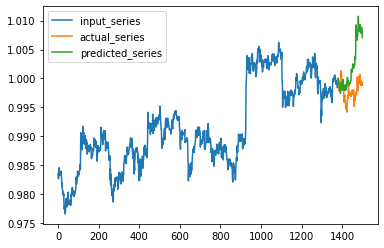

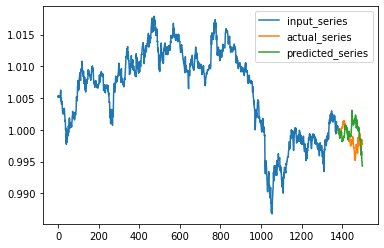

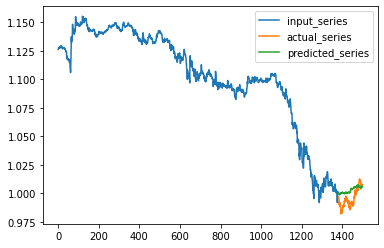

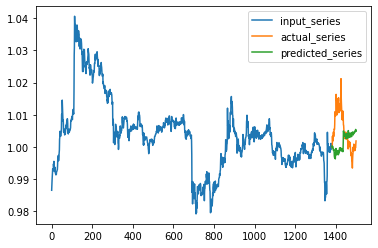

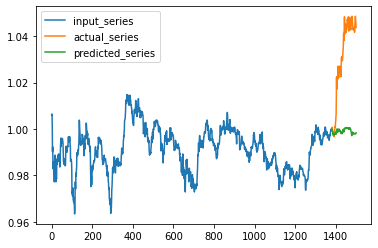

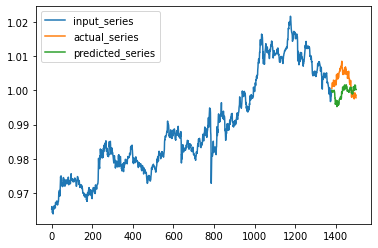

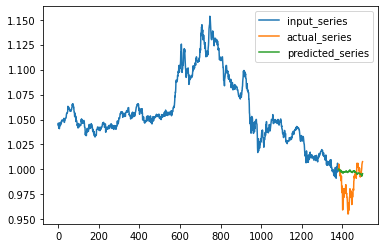

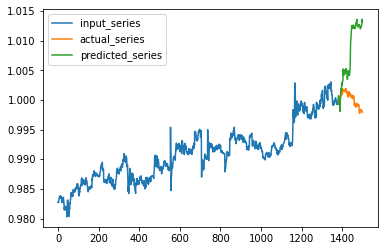

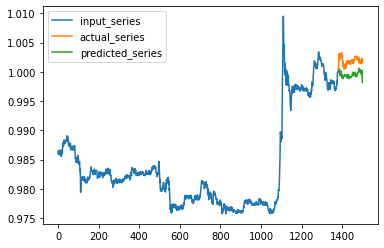

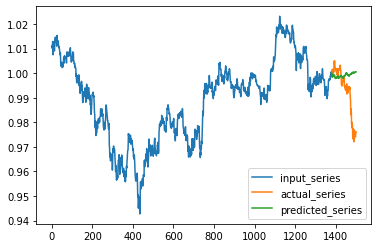

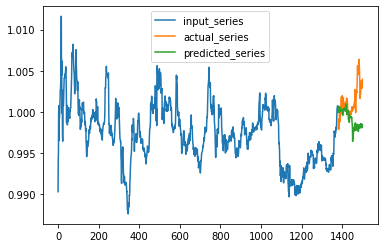

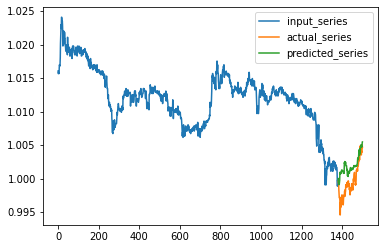

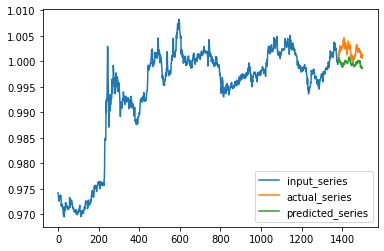

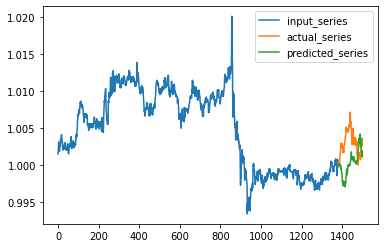

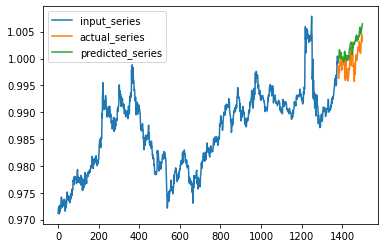

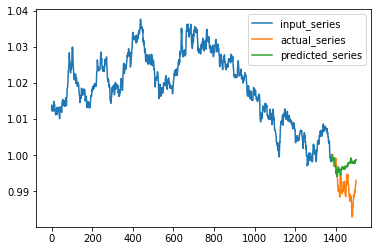

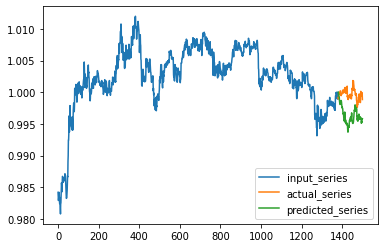

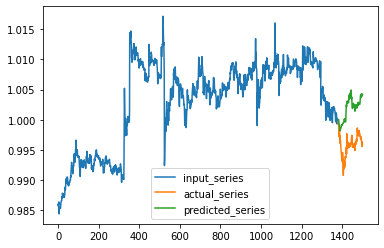

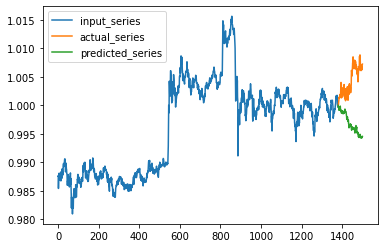

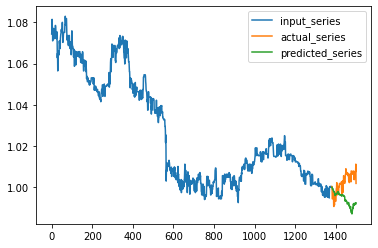

In [50]:
y_train_open = y_train[:,:,1]

for i in range(20): 
    plt.plot() 
    plot_series(x_train_open[i,:], y_train_open[i,:], pred_train[i,:])
    plt.show()